In [227]:
import sys
sys.path.append('../')
sys.path.append('/home/diego/python/convolution-kernels/')
sys.path.append('/home/diego/python/spike-train/')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from torch.nn.functional import conv1d

from gglm.glm.base import GLM
from gglm.glm.mmdglm import MMDGLM
from gglm.glm.torchglm import TorchGLM
from kernel.rect import KernelRect
from kernel.values import KernelBasisValues
from sptr.sptr import SpikeTrain
from signals import auto_covariance

In [159]:
class SurMMDGLM(torch.nn.Module):
    
    def __init__(self, b, eta):
        super(SurMMDGLM, self).__init__()
#         self.b = b
        self.eta = eta
        
        self.register_parameter("b", torch.nn.Parameter(b))
        
        eta_coefs = torch.from_numpy(eta.coefs).float()
        self.register_parameter("eta_coefs", torch.nn.Parameter(eta_coefs))
        
    def run(self, dt, T, shape=(1,), full=False):
        
        shape = (T, ) + shape
        
        eta_conv = torch.zeros(shape, requires_grad=False)
        mask_spikes = []
        
        eta_basis = torch.from_numpy(self.eta.interpolate_basis(np.arange(0, eta.support[1], 1))).float()
#         print(eta_basis.shape)
        eta_vals = torch.matmul(eta_basis, self.eta_coefs)
        T_eta = eta_vals.shape[0]

        for t in range(T):

            u = self.b + eta_conv[t, ...]
            r = torch.exp(u)
            p_spk = 1 - torch.exp(-r * dt)
            
            rand = torch.rand(*shape[1:])
            _mask_spikes = spike_fn(p_spk - rand)
            mask_spikes.append(_mask_spikes)
            
#             eta_conv[t + 1:min(T, t + 1 + T_eta), :] += _mask_spikes.detach()[None, :] * eta_vals[:min(T_eta, T - t - 1), None]
            
            if self.eta is not None and t < T - 1:
# #                 eta_conv[t + 1:min(T, t + 1 + T_eta), mask_spikes[t, ...].detach() > 0] += eta_vals[:min(T_eta, T - t - 1), None]
                eta_conv[t + 1:min(T, t + 1 + T_eta), _mask_spikes.detach() > 0] += eta_vals[:min(T_eta, T - t - 1), None]
#                 eta_conv[t + 1:min(T, t + 1 + T_eta), _mask_spikes.detach() > 0] += _mask_spikes * eta_vals[:min(T_eta, T - t - 1), None]
        
        if full:
            return kappa_conv, eta_conv, u, r, mask_spikes
        else:
            return u, mask_spikes
        
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 1000.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (1.0 + SurrGradSpike.scale*torch.abs(input))**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

# def spike_fn(x):
#     out = torch.zeros_like(x)
#     out[x > 0] = 1.0
#     return out

In [160]:
# f = h5py.File('../cool_stuff/h5test.h5', "r")

# arg_spikes = (torch.tensor(f['MC']['spikeTimes'], dtype=int)[:, 0], torch.tensor(f['MC']['spikeIndices'], dtype=int)[:, 0] - 1)

# dt = 1
# t = torch.arange(0, 1000, dt)
# mask_spikes_train = torch.zeros((len(t), 10), dtype=bool)
# mask_spikes_train[arg_spikes] = True

# n_spk_train = np.sum(mask_spikes_train)
# fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
# nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)

# st_train = SpikeTrain(t, mask_spikes_train)

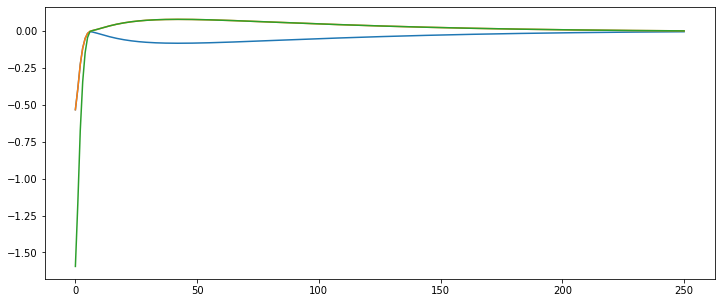

In [203]:
def raised_cosine(t, b, c, dc, a=1e0):
    basis = (1 + np.cos(np.maximum(-np.pi, np.minimum(a * (np.log(t + b) - c) * np.pi / dc / 2, np.pi)))) / 2
    basis = basis / np.sqrt(np.sum(basis**2, 0))
    return basis

def orthogonalize(basis):
    u, s, v = np.linalg.svd(basis)
    basis = u[:, :basis.shape[1]]
    return basis

dt = 1
t_ker = np.arange(0, 251, dt)

b = dt
ctrs = np.array([0, 1.2 * np.pi])
db = 1

basis = raised_cosine(t_ker[:, None], b, ctrs[None, :], db)
basis = orthogonalize(basis)

a = 1

fig, ax = plt.subplots(figsize=(12, 5))
# ax.plot(t_ker, basis)

# eta_coefs = np.array([3.0, -1.0])
eta_coefs = np.array([1.0, 2.0])
ax.plot(t_ker, basis)
ax.plot(t_ker, np.dot(basis, eta_coefs))

eta = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs)

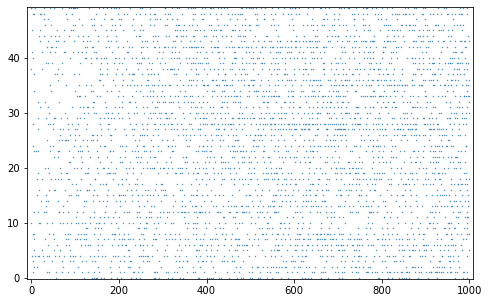

In [204]:
tbins = np.concatenate((np.arange(0, 10, 2), np.arange(10, 100, 10), np.arange(100, 550, 50)))
# eta = KernelRect(tbins, -np.exp(-tbins[:-1] / 50))
# eta = KernelRect(tbins, np.zeros(len(tbins) - 1))
b = torch.tensor([-3.])

# glm_true = GLM(b, eta)
glm_true = TorchGLM(u0=-3, eta=eta.copy())

dt, T = 1, 1000
t = np.arange(0, T, dt)
# u, mask_spikes_train = glm_true.run(1, 1000, shape=(50,))
u, r, mask_spikes_train = glm_true.sample(t, shape=(50,))
mask_spikes_train = torch.from_numpy(mask_spikes_train)
# mask_spikes_train = torch.stack()

st_train = SpikeTrain(t, mask_spikes_train.detach().numpy())
st_train.plot(ms=0.4)

In [205]:
# t = np.arange(0, 1000, 1)
# np.random.seed(0)
# n = 50
# glm_true = TorchGLM(u0=-4.5, eta=eta_true)
# _, _, mask_spikes = glm_true.sample(t, shape=(n, ))
# st = SpikeTrain(t, mask_spikes)
# n_spk = np.sum(mask_spikes)
# fr = np.mean(np.sum(mask_spikes, 0) / (t[-1] - t[0] + t[1]) * 1000)
# nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes)
# autocov = np.mean(auto_covariance(mask_spikes, method='fft', subtract_mean=False, 
#                                          stationary_signal=False, biased=False), 1)
# isi = st.isi_distribution()
# mean_isi = np.mean(isi)

# fig, ax = plt.subplots(figsize=(10, 5))
# st.plot(ax=ax)

In [206]:
def phi_fr(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    return torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T

def phi_autocov(t, mask_spikes, padding=250):
    T = len(t)
    mask_spikes = mask_spikes.float().clone()
    autocov = conv1d(mask_spikes.T[None, :, :], mask_spikes.T[:, None, :], padding=padding, groups=mask_spikes.shape[1]) / T
    autocov = autocov[0, :, (padding - 1):].T
    return autocov

def ker_fr(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    return fr1[:, None] * fr2[None, :]

def ker_sch_heavi(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    cum1 = torch.cumsum(mask_spikes1, dim=0)
    cum2 = torch.cumsum(mask_spikes2, dim=0)
    gramian = torch.exp(-torch.sum((cum1[:, :, None] - cum2[:, None, :])**2, dim=0) / sd2)
    return gramian

def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    T = st_train.t[-1] - st_train.t[0] + st_train.t[1]
    mask = np.array(st_train.mask, dtype=bool)
    u_dc, r_dc = model.sample_conditioned(st_train.t, mask)
    nll = -(np.sum(np.log(1 - np.exp(-dt * r_dc[mask]) + 1e-24) ) - \
                dt * np.sum(r_dc[~mask]))
    return dict(nll=nll)

In [215]:
phi, kernel, lam_mmd, biased, lr = phi_autocov, None, 5e3, True, 1e-2
padding = 100

log_likelihood = False
beta0, beta1 = 0, 0
n_batch_fr = 50
num_epochs = 250
n_metrics = 1

time0 = time.time()

# u00 = (glm_true.b.detach().clone() * 1.2).numpy()
# eta0 = glm_true.eta.copy()
u00 = -4.2
eta0 = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=np.zeros(basis.shape[1]))

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = torch.optim.Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, mask_spikes_train.detach(), phi=phi, kernel=kernel, 
                                                log_likelihood=log_likelihood, 
                                              n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim,
                                                num_epochs=num_epochs, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
# nll_normed_mmd = (metrics_mmd['nll'] - nll_pois_proc_train) / np.log(2) / n_spk
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(st_train.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)

# _, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
# isi_fr_mmd = st_fr_mmd.isi_distribution()
# mean_isi_fr_mmd = np.mean(isi_fr_mmd)
# r_dc_mmd, r_fr_mmd = r_dc_mmd * 1000, r_fr_mmd * 1000

# _, r_fr_mmd_long, mask_spikes_fr_mmd_long = mmdglm.sample(t_long, shape=(st_train.mask.shape[1],))
# st_fr_mmd_long = SpikeTrain(t_long, mask_spikes_fr_mmd_long)
# isi_fr_mmd_long = st_fr_mmd_long.isi_distribution()
# mean_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
# r_fr_mmd_long = r_fr_mmd_long * 1000
# autocov_mmd_long = np.mean(auto_covariance(mask_spikes_fr_mmd_long, method='fft', 
#                                            subtract_mean=False, stationary_signal=False, biased=False), 1)

# time1 = time.time()
# print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

 epoch 249 of 250 loss 7315.5030115746868 250 loss 901.3858179668

In [216]:
# def mmd(mask_spikes_fr, mask_spikes_d):
#     idx_fr = np.triu_indices(mask_spikes_fr.shape[1], k=1)
#     idx_fr = (torch.from_numpy(idx_fr[0]), torch.from_numpy(idx_fr[1]))
#     idx_d = np.triu_indices(mask_spikes_d.shape[1], k=1)
#     idx_d = (torch.from_numpy(idx_d[0]), torch.from_numpy(idx_d[1]))
#     gramian_d_d = kernel(t, mask_spikes_d, mask_spikes_d)
#     gramian_fr_fr = kernel(t, mask_spikes_fr, mask_spikes_fr)
#     gramian_d_fr = kernel(t, mask_spikes_d, mask_spikes_fr)
#     mmd = torch.mean(gramian_d_d[idx_d]) + torch.mean(gramian_fr_fr[idx_fr]) \
#                                 -2 * torch.mean(gramian_d_fr)
#     return mmd

In [217]:
from gglm.metrics import _mmd_from_features

In [218]:
# def loss(mask_spikes, mask_spikes_train):
#     n_spikes = torch.sum(mask_spikes) / mask_spikes.shape[1]
#     n_spikes_train = torch.sum(mask_spikes_train) / mask_spikes_train.shape[1]
#     return (n_spikes - n_spikes_train)**2

# tbins = np.concatenate((np.arange(0, 10, 2), np.arange(10, 100, 10), np.arange(100, 1000, 50)))
# eta = KernelRect(tbins, -np.exp(-tbins[:-1] / 50))
eta0 = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=np.zeros(basis.shape[1]))
b = torch.tensor([-4.2])
smmdglm = SurMMDGLM(b, eta0)
optimizer = torch.optim.Adam(smmdglm.parameters(), lr=1e-2, betas=(0, 0))

phi_d = phi(t, mask_spikes_train, padding=padding)

dt, T = 1, 1000
t = np.arange(0, T, dt)

num_epochs = 250

loss_hist = []
for e in range(num_epochs):
    if e > 0:
        print('\r', 'epoch', e, 'of', num_epochs, 
                          'loss', np.round(loss_val.item(), 10), end='')
    u, mask_spikes = smmdglm.run(dt, T, shape=(50,))
    mask_spikes = torch.stack(mask_spikes)
    phi_fr = phi(t, mask_spikes, padding=padding)
#     m,_=torch.max(output,1)
#     log_p_y = log_softmax_fn(m)
#     loss_val = loss(mask_spikes, mask_spikes_train.clone())
#     loss_val = mmd(mask_spikes, mask_spikes_train.clone())
    loss_val = _mmd_from_features(t, phi_d, phi_fr, biased=biased)

    optimizer.zero_grad()
#     loss_val.backward()
    loss_val.backward(retain_graph=True)
#     print(glm.b.grad, glm.eta_coefs.grad, glm.b.detach())
    optimizer.step()
    loss_hist.append(loss_val.item())

 epoch 249 of 250 loss 0.0016604397

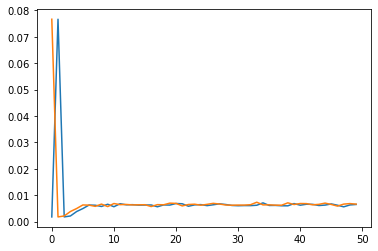

In [233]:
autocov_train = np.mean(auto_covariance(mask_spikes_train.numpy(), method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)
plt.plot(torch.mean(phi_d, 1)[:50])
plt.plot(autocov_train[:50])

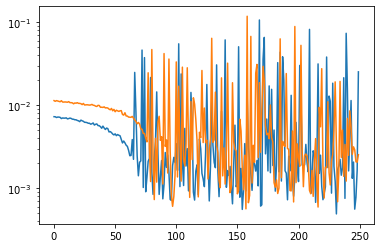

In [220]:
plt.plot(loss_hist)
plt.plot(metrics_mmd['mmd'])
plt.yscale('log')

-3.0 -3.3999998101025413


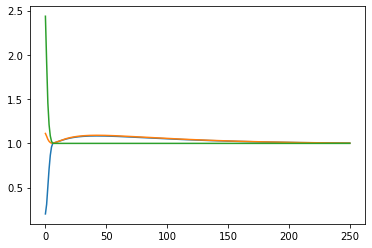

In [221]:
print(glm_true.b.detach().item(), mmdglm.b.detach().item())

fig, axeta = plt.subplots()

glm_true.eta.plot(t_ker, exp_values=True, ax=axeta)
mmdglm.eta.plot(t_ker, exp_values=True, ax=axeta)
axeta.plot(np.exp(np.dot(basis, glm.eta_coefs.detach().numpy())))

In [ ]:
plt.plot(loss_hist)

In [ ]:
dt, T = 1, 1000
t = np.arange(0, T, dt)
u, mask_spikes = glm.run(1, 1000, shape=(10,))
# basis = torch.from_numpy(eta.interpolate_basis(np.arange(0, eta.support[1], 1))).float()
mask_spikes = torch.stack(mask_spikes)

# optimizer = torch.optim.SGD(glm.parameters(), lr=2e-1)
# optimizer = torch.optim.SGD([glm.b], lr=2e-1)
# loss_val = torch.sum(mask_spikes)

# optimizer.zero_grad()
# print(glm.b.grad, glm.eta_coefs.grad)
# loss_val.backward()
# print(glm.b.grad, glm.eta_coefs.grad, glm.b)
# optimizer.step()
# print(glm.b.grad, glm.eta_coefs.grad, glm.b)
# loss_hist.append(loss_val.item())

st = SpikeTrain(t, mask_spikes.detach().numpy())
st.plot()

In [ ]:
torch.sum(mask_spikes) / mask_spikes.shape[1]

In [ ]:
mask_spikes.grad_fn

In [ ]:
[i for i in glm.parameters()]